# Epidemiology vs. Literature-Based Comorbidity

This notebook compares the epidemiological results reviewed by Keezer *et al.* in [Comorbidities of epilepsy: current concepts and future perspectives](https://www.ncbi.nlm.nih.gov/pubmed/26549780) with the literature-based genetic pleiotropy scores presented by Hoyt and Domingo-Fernández *et al.* in [A systematic approach for identifying shared mechanisms in epilepsy and its comorbidities](https://doi.org/10.1101/269860).

In [1]:
import itertools as itt
import logging
import os
import sys
import time

import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

In [2]:
%matplotlib inline
%config InlineBackend.figure_format = 'svg'

In [3]:
log = logging.getLogger(__name__)

In [4]:
print(sys.version)

3.6.4 (default, Jan  6 2018, 11:51:59) 
[GCC 4.2.1 Compatible Apple LLVM 9.0.0 (clang-900.0.39.2)]


In [5]:
print(time.asctime())

Thu Apr 19 22:17:12 2018


In [6]:
current_working_directory = os.getcwd() # Notebook abs path
resources_directory = os.path.join(current_working_directory, "resources")
results_directory = os.path.join(current_working_directory, "results")

# Load Data

## Epidemoiological Findings

The table from Keezer *et al.* was manually extracted to a computer-readable TSV file available at https://github.com/cthoyt/EpiCom/blob/master/results/keezer_table.tsv. 

In [7]:
keezer_df_path = os.path.join(results_directory, 'keezer_table.tsv')

The [BRFSS](https://www.cdc.gov/mmwr/preview/mmwrhtml/ss5706a1.htm), [CHIS](https://www.ncbi.nlm.nih.gov/pubmed/18983943), [CHS 2007](https://www.ncbi.nlm.nih.gov/pubmed/16393162), and [NHIS 2010](https://www.ncbi.nlm.nih.gov/pubmed/24172878) studies compared each condition's prevalence as a comorbidity in epilepsy subpopulations with the general population. The ratio of these values (epilepsy prevalence / general population prevalence) was used to calculate the prevalence ratio and make these results comparable to the remaining studies, which only reported the prevalence ratios.

In [8]:
keezer_df = pd.read_csv(keezer_df_path, sep='\t')
keezer_df.head()

,Condition,ICD Chapter,Reference,Epilepsy Subpopulation,General Popualation,Prevalence Rate
0,Neoplasm,2,CHIS,11.1,7.9,1.405063
1,Neoplasm,2,CHS 2005,NaN,NaN,1.400000
2,Neoplasm,2,NHIS 2002,NaN,NaN,2.400000
3,Neoplasm,2,NHIS 2010,11.3,8.1,1.395062
4,Neoplasm,2,NPHS,NaN,NaN,1.200000


## Load Literature-Based Gene Overlap Findings

In [9]:
gene_df_path = os.path.join(results_directory, 'gene_overlap_results.tsv')
gene_df = pd.read_csv(gene_df_path, sep='\t')

In [10]:
scaiview_map = {
    'Pulmonary Disease, Chronic Obstructive': 'copd',
    'bronchitis chronic': 'chronic bronchiti'
}

gene_df.Condition = gene_df.Condition.map(lambda x: scaiview_map.get(x, x))

Show the first few rows

In [11]:
gene_df.head()

,Condition,MeSH ID,Reference Query,Associated documents,Disease-associated genes,Comorbidity-associated genes,Normalized pleitropy rate (%)
0,Epilepsy,D004827,"[MeSH Disease:""Epilepsy""]",192245,2901,-,-
1,Alzheimer's Disease,D000544,"[MeSH Disease:""Alzheimer Disease""]",109495,4968,396,13.65
2,Migraine,D008881,"[MeSH Disease:""Migraine Disorders""]",30928,1230,306,10.54
3,Parkinson's Disease,D010300,"[MeSH Disease:""Parkinson Disease""]",79103,3646,258,8.89
4,Hypertension,D006973,"[MeSH Disease:""Hypertension""]",391190,5574,252,8.68


#  Compare

## Representation of Conditions

First, the representation of each condition in each data set is checked. This shows that there are several conditions mentioned by Keezer that we do not yet have from SCAIView.

In [12]:
a = {x.lower().rstrip('s') for x in keezer_df.Condition.unique()}
b = {x.lower().rstrip('s') for x in gene_df.Condition.unique()}

Diseases we have from Keezer but not SCAIView

In [13]:
sorted(a - b)

['allergie',
 'back problem',
 'bowel disorder',
 'chronic bronchiti',
 'heart disease',
 'major depression',
 'neoplasm',
 'stroke',
 'thyroid condition']

Diseases from SCAIView but not Keezer

In [14]:
sorted(b - a)

['bronchitis chronic', 'epilepsy', "parkinson's disease"]

## Combining Data Frames

The dataframes from Keezer and Hoyt/Domingo-Fernández are sliced to compare the relevant values.

In [15]:
keezer_slim_df = keezer_df[['Condition', 'Prevalence Rate']]
gene_slim_df = gene_df[['Condition', 'Normalized pleitropy rate (%)']]

In [16]:
def disease_name_equal(a, b):
    return a.casefold().rstrip('s') == b.casefold().rstrip('s')

In [17]:
data = []

iterator = itt.product(keezer_slim_df.itertuples(), gene_slim_df.itertuples())

for (_, epidem_cond, epidem_val), (_, gene_cond, gene_val) in iterator:
    if not disease_name_equal(epidem_cond, gene_cond):
        continue
    
    if pd.isnull(epidem_val) or pd.isnull(gene_val):    
        if pd.isnull(epidem_val):
            log.warning('epidemiology value is null for %s %s', epidem_cond, gene_val)
        if pd.isnull(gene_val):
            log.warning('gene value is null for %s %s', epidem_cond, epidem_val)
        continue
        
    data.append((epidem_cond, float(epidem_val), float(gene_val)))

compare_df = pd.DataFrame(
    data, 
    columns=[
        'Condition', 
        'Prevalence Ratio from Epidemiological Studies', 
        'Normalized Literature Pleitropy Rate (%)'
    ]
)
compare_df = compare_df.sort_values('Condition')

## Plotting Comparisons

For each disease, several prevalence ratios are plotted versus a single literature-based pleitropy rate. While Alzheimer's disease and dementia all have both high values for both measurements, there is no general trend/correlation.

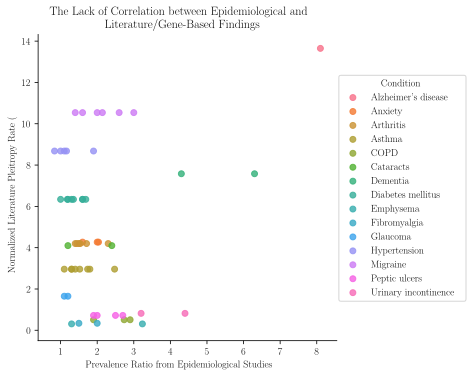

In [18]:
sns.lmplot(
    x='Prevalence Ratio from Epidemiological Studies', 
    y='Normalized Literature Pleitropy Rate (%)', 
    data=compare_df, 
    fit_reg=False, 
    hue='Condition', 
    legend=True
)
plt.title('The Lack of Correlation between Epidemiological and \nLiterature/Gene-Based Findings')
plt.show()

Even after aggregating the results for each conditions using the algebraic mean, there is still a lack of correlation.

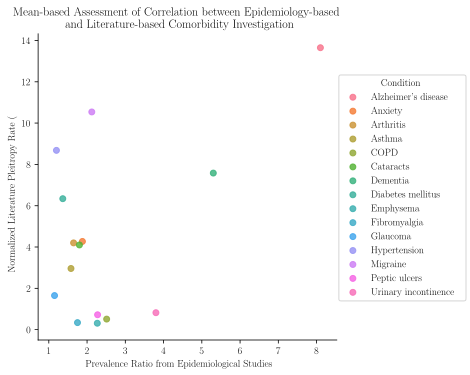

In [19]:
sns.lmplot(
    x='Prevalence Ratio from Epidemiological Studies', 
    y='Normalized Literature Pleitropy Rate (%)',  
    data=compare_df.groupby('Condition').mean().reset_index(level=0), 
    hue='Condition', 
    fit_reg=False, 
    legend=True
)
plt.title('Mean-based Assessment of Correlation between Epidemiology-based\n'
          'and Literature-based Comorbidity Investigation')
plt.show()

Using the median instead of the mean to reduce the effect of outliers is also unsuccessful at identifying a clear correlation.

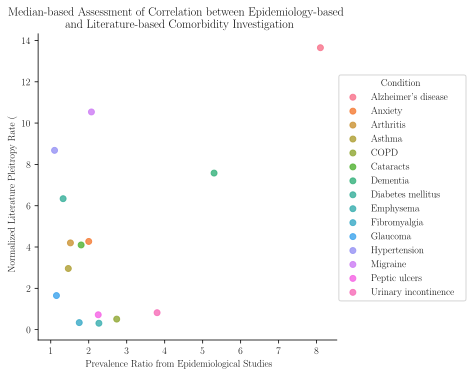

In [20]:
sns.lmplot(
    x='Prevalence Ratio from Epidemiological Studies', 
    y='Normalized Literature Pleitropy Rate (%)',  
    data=compare_df.groupby('Condition').median().reset_index(level=0), 
    hue='Condition', 
    fit_reg=False, 
    legend=True
)
plt.title('Median-based Assessment of Correlation between Epidemiology-based\n'
          'and Literature-based Comorbidity Investigation')
plt.show()

# Conclusion

As Keezer *et al.* plotted in Figure 1 of their manuscript, comorbidities arise due one or many of causative mechanisms, resultant mechanisms, shared risk factors, and bidirectional effects. The deconvolution of these types of comorbidities are much more complicated than can be explained solely by literature-based gene co-occurrence as a proxy for genetic pleiotropy. As the figure above shows, there is little correlation to use this without much further investigation into the mechanisms in which those genes participate.